# things to try:
1. add lack variable to all bytes along with difference var (e.g. byte0.shift(1) - byte0)
2. add time shift variable to timstanps
3. Try sum of bytes

# Methods:
1. STL decompostion. break TS into seasonality, trend and residuals and analyze redisuals.
2. Isolation Forest. Tree based approach that splits the data into branches. Shorter branches are created by anomalies
3. Forecasting. Predict next values and if the new ones deviates from the prediction -> anomaly
4. K-means. Create K clusters based on Elbow method. Than calculate distance to each observation. If the distance is longer than a threshold -> outlier.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDOneClassSVM
from sklearn.svm import OneClassSVM
from sklearn.kernel_approximation import Nystroem
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, make_scorer, f1_score, recall_score, precision_score, accuracy_score
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler

sns.set_theme()
%matplotlib inline
plt.rcParams['figure.dpi'] = 140

In [2]:
normal = pd.read_csv('hacker_dataset/attack_free_data.csv')
gear = pd.read_csv('hacker_dataset/gear_dataset.csv')

#rpm = pd.read_csv('hacker_dataset/RPM_dataset.csv')
#test_dos = pd.read_csv('hacker_dataset/DoS_dataset.csv')
#test_fuzzy = pd.read_csv('hacker_dataset/Fuzzy_dataset.csv')

In [3]:
# identify the ID of the gear message
gearID = pd.unique(gear[gear.Flag=='T'].CAN_ID)[0]
print(f"spoofed gear message ID: {gearID}")

gear_norm = normal[normal.CAN_ID==gearID].reset_index(drop=True)
gear_attack = gear[gear.CAN_ID==gearID].reset_index(drop=True)


spoofed gear message ID: 043f


In [4]:
def convertToDec(df, cols):
    '''Converts hex values of df stored in cols into dec'''
    result = df.copy()
    for col in cols:
        result.loc[:, col] = result.loc[:, col].apply(lambda x: int(x, 16)).astype('float')
    return result

In [5]:
# list of byte columns
byteX = ['byte0',
        'byte1',
        'byte2',
        'byte3',
        'byte4',
        'byte5',
        'byte6',
        'byte7']

In [6]:
gear_norm = convertToDec(gear_norm, byteX)
gear_attack = convertToDec(gear_attack, byteX)

It seems that we have more spoofed messages in the dataset than normal ones...

# Feature engineering

## Gradient of bytes

In [7]:
# deduct shifted values from the current ones to find gradients
#gear_norm.loc[:, byteX] = gear_norm.loc[:, byteX] - gear_norm.loc[:, byteX].shift(1)
#gear_norm.drop(index=0, inplace=True)
#gear_norm.head(5)

In [8]:
#gear_attack.loc[:, byteX] = gear_attack.loc[:, byteX] - gear_attack.loc[:, byteX].shift(1)
#gear_attack.drop(index=0, inplace=True)
#gear_attack.head(5)

The algorithms will work much better if we add some outliers to the training 
data. As the portion of attack messages are about 70% in the joint dataset it
makes them not so outliers. Therefore, we create our traning dataset based on 
the attack-free set with addition of some attacks to have proportion about 
95/5 % normal/attack. 

In [9]:
attack_msgs = gear_attack[gear_attack.Flag=='T']
normal_msgs = gear_attack[gear_attack.Flag=='R']

In [10]:
print(attack_msgs.shape)
print(normal_msgs.shape)

(597252, 12)
(207289, 12)


In [11]:
# percent of attack messages that needs to be sampled out of all_gear dataset
# to have proportion mentioned above (95/5 %)
perc_frac_train = 0.0042
perc_frac_test = 0.022

outliers_train = attack_msgs.sample(frac=perc_frac_train).reset_index(drop=True)
outliers_test = attack_msgs.sample(frac=perc_frac_test).reset_index(drop=True)

In [12]:
print(outliers_train.shape)
print(outliers_test.shape)

(2508, 12)
(13140, 12)


In [13]:
train = pd.concat([gear_norm, outliers_train], axis=0)
print(f"Percentage attack messages in train: {train[train.Flag=='T'].shape[0]/train.shape[0]}")
train.head(4)

Percentage attack messages in train: 0.047188093849366876


,Timestamp,CAN_ID,DLC,byte0,byte1,byte2,byte3,byte4,byte5,byte6,byte7,Flag
0,1.479121e+09,043f,8.0,0.0,64.0,96.0,255.0,90.0,108.0,8.0,0.0,NaN
1,1.479121e+09,043f,8.0,0.0,64.0,96.0,255.0,90.0,106.0,8.0,0.0,NaN
2,1.479121e+09,043f,8.0,0.0,64.0,96.0,255.0,90.0,106.0,8.0,0.0,NaN
3,1.479121e+09,043f,8.0,0.0,64.0,96.0,255.0,90.0,106.0,8.0,0.0,NaN


In [14]:
test = pd.concat([normal_msgs, outliers_test], axis=0)
print(f"Percentage attack messages in test: {test[test.Flag=='T'].shape[0]/test.shape[0]}")
test.head(4)

Percentage attack messages in test: 0.059611031216400746


,Timestamp,CAN_ID,DLC,byte0,byte1,byte2,byte3,byte4,byte5,byte6,byte7,Flag
0,1.478193e+09,043f,8,16.0,64.0,96.0,255.0,120.0,196.0,8.0,0.0,R
1,1.478193e+09,043f,8,16.0,64.0,96.0,255.0,120.0,195.0,8.0,0.0,R
2,1.478193e+09,043f,8,16.0,64.0,96.0,255.0,120.0,194.0,8.0,0.0,R
3,1.478193e+09,043f,8,16.0,64.0,96.0,255.0,120.0,194.0,8.0,0.0,R


In [15]:
# normalize values in byteX features
#train_extend.loc[:, byteX_diffX] = np.log1p(train_extend.loc[:, byteX_diffX].astype(float))
#test_gear_extend.loc[:, byteX_diffX] = np.log1p(test_gear_extend.loc[:, byteX_diffX].astype(float))

# Train/Validation/Test sets split

In [16]:
X_train = train.loc[:, byteX].sample(frac=1).reset_index(drop=True)
print(X_train.shape)
X_train.head(4)

(53149, 8)


,byte0,byte1,byte2,byte3,byte4,byte5,byte6,byte7
0,1.0,69.0,96.0,255.0,91.0,248.0,8.0,0.0
1,3.0,69.0,96.0,255.0,94.0,38.0,21.0,0.0
2,3.0,69.0,96.0,255.0,104.0,110.0,11.0,0.0
3,7.0,71.0,96.0,255.0,108.0,181.0,1.0,0.0


In [17]:
# validation set 
X_val, X_test = train_test_split(test.loc[:, byteX+['Flag']], train_size=0.5, random_state=42)

In [18]:
X_val.reset_index(drop=True, inplace=True)
print(X_val.shape)

(110214, 9)


In [19]:
X_test.reset_index(drop=True, inplace=True)
print(X_test.shape)

(110215, 9)


In [20]:
y_val = X_val.loc[:, 'Flag'].rename({'Flag': 'y_val_true'})
X_val.drop('Flag', axis=1, inplace=True)

y_test = X_test.loc[:, 'Flag'].rename({'Flag': 'y_test_true'})
X_test.drop('Flag', axis=1, inplace=True)

In [21]:
# replace 'T' and 'R' values with -1/1
y_val = y_val.replace({'T':-1, 'R':1})
y_test = y_test.replace({'T':-1, 'R':1})

In [22]:
print(f"y_train: {X_train.shape}")
print(f"y_val: {y_val.shape}")
print(f"x_val: {X_val.shape}")
print(f"y_test: {y_test.shape}")
print(f"x_test: {X_test.shape}")

y_train: (53149, 8)
y_val: (110214,)
x_val: (110214, 8)
y_test: (110215,)
x_test: (110215, 8)


# Modeling

In [23]:
def plot_confmat(Y, Y_hat):
    '''Plots confusion matrix for true/predicted values'''
    
    # total number of samples
    n = Y.shape[0]
    # coef to convert absolute number of samples into percentage
    coef = 100/n

    tn, fp, fn, tp = confusion_matrix(Y, Y_hat, labels=[1, -1]).ravel()
    cm = pd.DataFrame(
        data=[[tp*coef, fn*coef],[fp*coef, tn*coef]],
        index=['attack', 'normal'],
        columns=['attack', 'normal'])

    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1 = 2*(precision*recall)/(precision+recall)
    #print(f'tn: {tn}')
    #print(f'fp: {fp}')
    #print(f'fn: {fn}')
    #print(f'tp: {tp}')

    #print(cm)
    #print(f"precision : {precision}")
    #print(f"recall : {recall}")
    #print(f"f1 : {f1}")
   
    _ = plt.figure(figsize=(4,4))
    ax = sns.heatmap(
        cm,
        annot=True,
        fmt='.3f',
        square=True
    )

    ax.set_title('Confusion Matrix (%)')
    ax.set_ylabel('True labels')
    ax.set_xlabel('Predicted labels')


# PCA

In [24]:
pca = PCA(n_components=2)

Xr_t = pd.DataFrame(pca.fit_transform(X_train), columns=['feat1', 'feat2'])
print(f"Variance retained for Xr_t: {pca.explained_variance_ratio_}")

Xr_v = pd.DataFrame(pca.fit_transform(X_val), columns=['feat1', 'feat2'])
print(f"Variance retained for Xr_v: {pca.explained_variance_ratio_}")

Xr_test = pd.DataFrame(pca.fit_transform(X_test), columns=['feat1', 'feat2'])
print(f"Variance retained for Xr_test: {pca.explained_variance_ratio_}")

Variance retained for Xr_t: [0.88456506 0.10376333]
Variance retained for Xr_v: [0.98999606 0.00727275]
Variance retained for Xr_test: [0.9900397  0.00725053]


<AxesSubplot:xlabel='feat1', ylabel='feat2'>

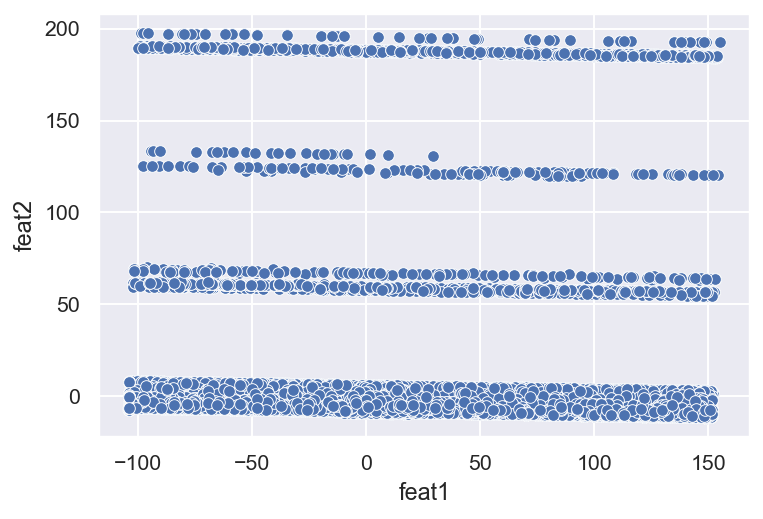

In [25]:
sns.scatterplot(x=Xr_t.feat1, y=Xr_t.feat2)

<AxesSubplot:xlabel='feat1', ylabel='feat2'>

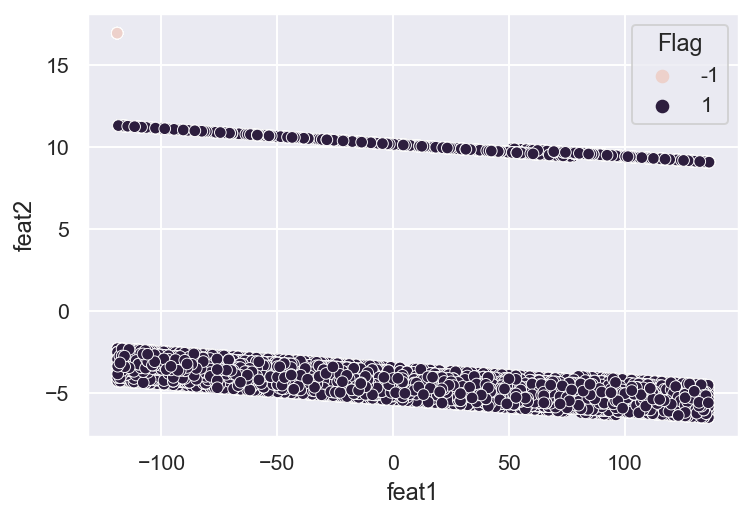

In [26]:
sns.scatterplot(x=Xr_v.feat1, y=Xr_v.feat2, hue=y_val)

# Isolation Forest

For regular bytesX: contamination=0.041

f1 score (Validation set): 0.0


C:\Users\dred\AppData\Local\Temp/ipykernel_15292/943467236.py:17: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2*(precision*recall)/(precision+recall)


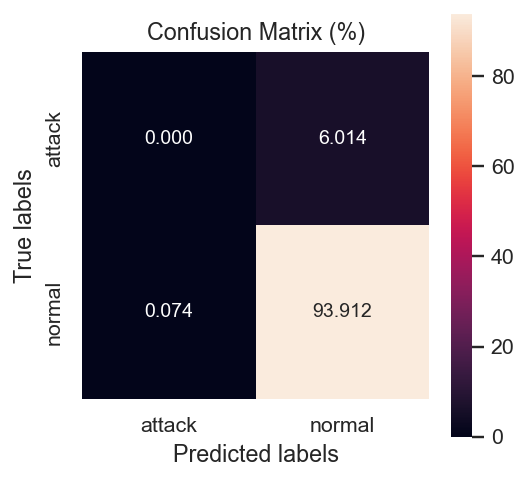

In [27]:
Iforest = IsolationForest(contamination=0.041)
Iforest.fit(Xr_t.values)
print(f"f1 score (Validation set): {f1_score(y_val, Iforest.predict(Xr_v.values), pos_label=-1)}")
plot_confmat(y_val.values, Iforest.predict(Xr_v.values))

f1 score (Test set): 0.0


C:\Users\dred\AppData\Local\Temp/ipykernel_15292/943467236.py:17: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2*(precision*recall)/(precision+recall)


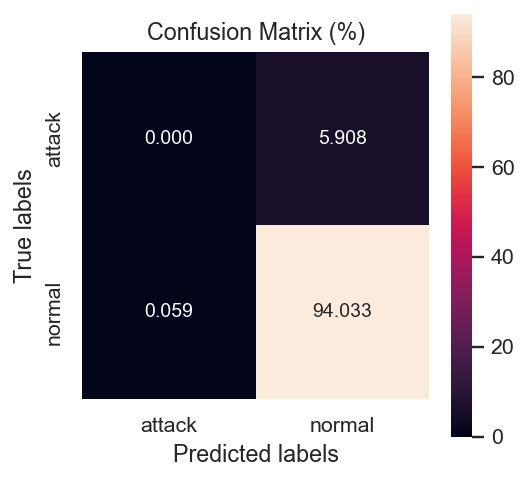

In [28]:
print(f"f1 score (Test set): {f1_score(y_test, Iforest.predict(Xr_test.values), pos_label=-1)}")
plot_confmat(y_test.values, Iforest.predict(Xr_test.values))

## SGDOneClassSVM

For regular byteX:

StandardScaler(),
    Nystroem(gamma=0.401), 
    SGDOneClassSVM(nu=0.041,
                    shuffle=True, 
                    fit_intercept=True, 
                    random_state=42,
                    tol=1e-4))

f1 score (Validation set): 0.6863770517268162


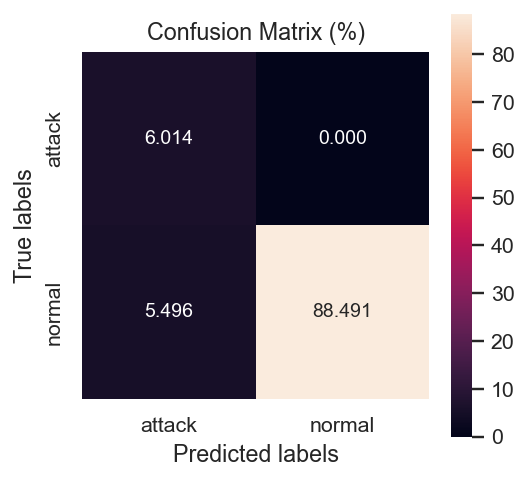

In [29]:
pipe_clf = make_pipeline(
    StandardScaler(),
    Nystroem(gamma=0.401), 
    SGDOneClassSVM(nu=0.041,
                    shuffle=True, 
                    fit_intercept=True, 
                    random_state=42,
                    tol=1e-4))

pipe_clf.fit(Xr_t)

print(f"f1 score (Validation set): {f1_score(y_val, pipe_clf.predict(Xr_v), pos_label=-1)}")
plot_confmat(y_val, pipe_clf.predict(Xr_v))

f1 score (Test set): 0.6631026933455527


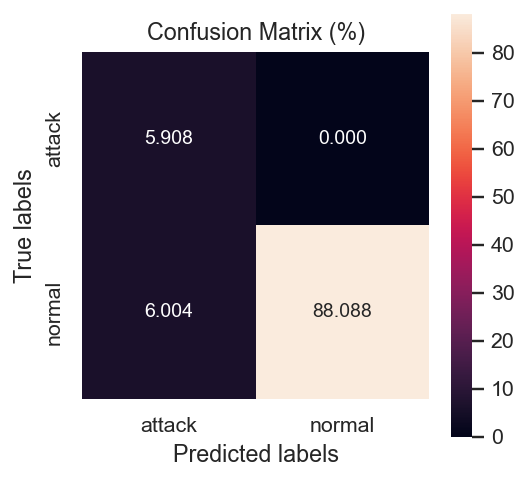

In [30]:

print(f"f1 score (Test set): {f1_score(y_test, pipe_clf.predict(Xr_test), pos_label=-1)}")
plot_confmat(y_test, pipe_clf.predict(Xr_test))